In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost mlflow streamlit category_encoders joblib


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import numpy as np

In [3]:
path = r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\india_housing_prices.csv"
df = pd.read_csv(path)

In [5]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample rows:")

Shape: (250000, 23)
Columns: ['ID', 'State', 'City', 'Locality', 'Property_Type', 'BHK', 'Size_in_SqFt', 'Price_in_Lakhs', 'Price_per_SqFt', 'Year_Built', 'Furnished_Status', 'Floor_No', 'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals', 'Public_Transport_Accessibility', 'Parking_Space', 'Security', 'Amenities', 'Facing', 'Owner_Type', 'Availability_Status']

Sample rows:


In [6]:
print(df.head(5))
print("\nMissing values (%):")
print((df.isna().sum()/len(df)*100).sort_values(ascending=False).head(20))
print("\nDtypes:")
print(df.dtypes)

   ID        State      City      Locality      Property_Type  BHK  \
0   1   Tamil Nadu   Chennai   Locality_84          Apartment    1   
1   2  Maharashtra      Pune  Locality_490  Independent House    3   
2   3       Punjab  Ludhiana  Locality_167          Apartment    2   
3   4    Rajasthan   Jodhpur  Locality_393  Independent House    2   
4   5    Rajasthan    Jaipur  Locality_466              Villa    4   

   Size_in_SqFt  Price_in_Lakhs  Price_per_SqFt  Year_Built  ...  \
0          4740          489.76            0.10        1990  ...   
1          2364          195.52            0.08        2008  ...   
2          3642          183.79            0.05        1997  ...   
3          2741          300.29            0.11        1991  ...   
4          4823          182.90            0.04        2002  ...   

  Age_of_Property  Nearby_Schools  Nearby_Hospitals  \
0              35              10                 3   
1              17               8                 1   
2    

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

for col in ['Price_in_Lakhs','Size_in_SqFt','Year_Built','BHK']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'Price_in_Lakhs' in df.columns and 'Size_in_SqFt' in df.columns:
    df['Price_per_SqFt'] = df['Price_in_Lakhs']*100000 / df['Size_in_SqFt']

current_year = 2025
if 'Year_Built' in df.columns:
    df['Age_of_Property'] = current_year - df['Year_Built']
else:
    df['Age_of_Property'] = np.nan

if 'Amenities' in df.columns:
    df['Amenities_count'] = df['Amenities'].fillna('').apply(lambda x: len([i for i in x.split(',') if i.strip()!='']))

num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(include=['object','category']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0] if not df[c].mode().empty else "Unknown")

out_path = r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\india_housing_prices_cleaned.csv"
df.to_csv(out_path, index=False)
print("Saved cleaned CSV to:", out_path)

Saved cleaned CSV to: C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\india_housing_prices_cleaned.csv


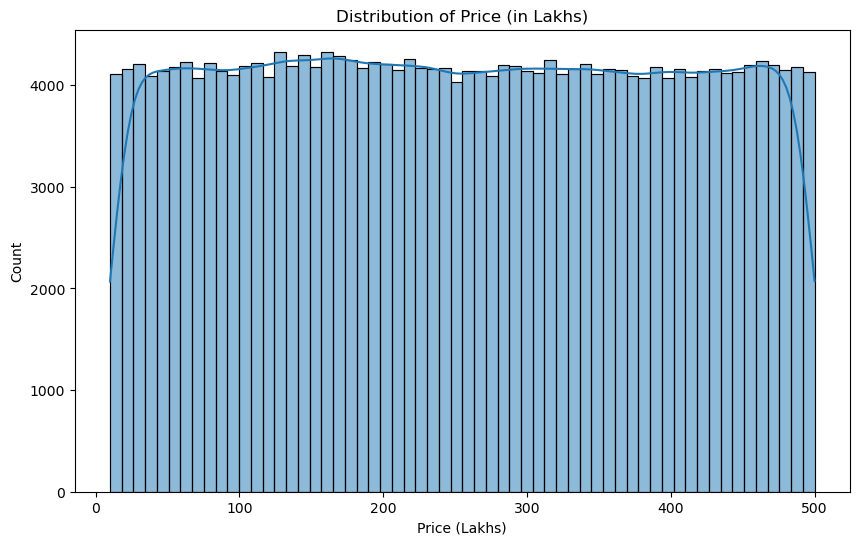

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10,6)
df = pd.read_csv(r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\india_housing_prices_cleaned.csv")

if 'Price_in_Lakhs' in df.columns:
    sns.histplot(df['Price_in_Lakhs'], bins=60, kde=True)
    plt.title('Distribution of Price (in Lakhs)')
    plt.xlabel('Price (Lakhs)')
    plt.show()

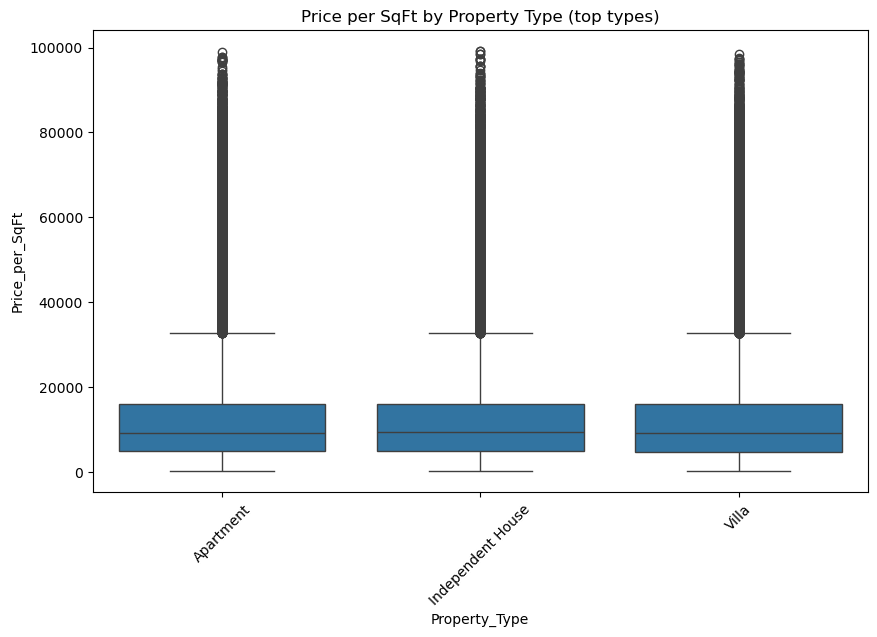

In [10]:
if 'Price_per_SqFt' in df.columns and 'Property_Type' in df.columns:
    top_types = df['Property_Type'].value_counts().nlargest(6).index
    sns.boxplot(data=df[df['Property_Type'].isin(top_types)], x='Property_Type', y='Price_per_SqFt')
    plt.title('Price per SqFt by Property Type (top types)')
    plt.xticks(rotation=45)
    plt.show()

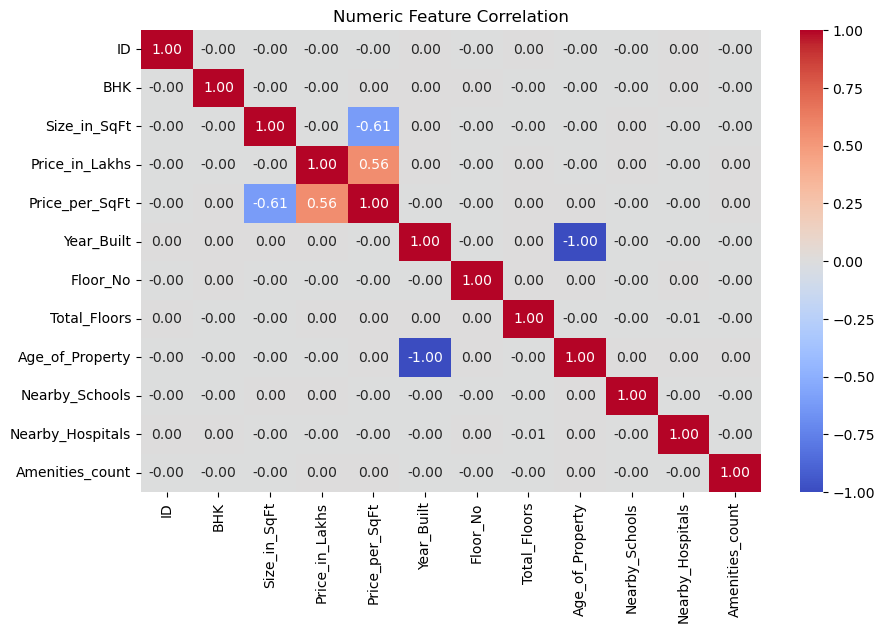

In [11]:
num = df.select_dtypes(include=['number']).corr()
sns.heatmap(num, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Numeric Feature Correlation")
plt.show()

In [12]:
if 'Locality' in df.columns and 'Price_in_Lakhs' in df.columns:
    top_loc = df.groupby('Locality')['Price_in_Lakhs'].median().sort_values(ascending=False).head(10)
    print("Top 10 localities by median price (Lakhs):")
    print(top_loc)

Top 10 localities by median price (Lakhs):
Locality
Locality_395    282.680
Locality_366    282.330
Locality_303    282.270
Locality_79     280.760
Locality_203    280.325
Locality_494    279.675
Locality_422    279.330
Locality_360    278.850
Locality_285    277.330
Locality_258    276.290
Name: Price_in_Lakhs, dtype: float64


In [13]:
if 'City' in df.columns and 'Price_per_SqFt' in df.columns:
    city_median = df.groupby('City')['Price_per_SqFt'].median().to_dict()
    df['City_Median_Price_per_SqFt'] = df['City'].map(city_median)

def is_good(row):
    cond1 = False
    if pd.notna(row.get('Price_per_SqFt')) and pd.notna(row.get('City_Median_Price_per_SqFt')):
        cond1 = row['Price_per_SqFt'] <= row['City_Median_Price_per_SqFt']
    cond2 = (row.get('Amenities_count',0) >= 3) and (row.get('Age_of_Property',999) <= 10) and (row.get('BHK',0) >= 3)
    return 1 if (cond1 or cond2) else 0

df['Good_Investment'] = df.apply(is_good, axis=1)

growth_rate_by_city = {}  
default_r = 0.08
def future_price(row, years=5):
    r = growth_rate_by_city.get(row.get('City'), default_r)
    return row['Price_in_Lakhs'] * ((1+r)**years)

df['Future_Price_5Y'] = df.apply(lambda r: future_price(r, years=5), axis=1)

out = r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\india_housing_with_targets.csv"
df.to_csv(out, index=False)
print("Saved with targets to:", out)

Saved with targets to: C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\india_housing_with_targets.csv


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
import pandas as pd
import joblib

num_features = ['Size_in_SqFt','BHK','Price_per_SqFt','Age_of_Property',
                'Nearby_Schools','Nearby_Hospitals','Amenities_count']

cat_low = ['Property_Type','Furnished_Status','Facing','Owner_Type']
cat_high = ['City','Locality']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_low_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

cat_high_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_enc', ce.CountEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat_low', cat_low_transformer, cat_low),
    ('cat_high', cat_high_transformer, cat_high)
], remainder='drop')

preprocessor.fit(df)
joblib.dump(preprocessor, r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\preprocessor.pkl")

print("Preprocessor saved successfully!")

Preprocessor saved successfully!


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib

features = [
    'Size_in_SqFt','BHK','Price_per_SqFt','Age_of_Property',
    'Nearby_Schools','Nearby_Hospitals','Amenities_count',
    'Property_Type','Furnished_Status','Facing','Owner_Type',
    'City','Locality'
]

X = df[features]
y_clf = df['Good_Investment']
y_reg = df['Future_Price_5Y']

X_train, X_test, y_clf_train, y_clf_test = train_test_split(
    X, y_clf, test_size=0.15, random_state=42
)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.15, random_state=42
)

clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=250,
        random_state=42,
        n_jobs=-1
    ))
])

clf_pipeline.fit(X_train, y_clf_train)

clf_preds = clf_pipeline.predict(X_test)
clf_probs = clf_pipeline.predict_proba(X_test)[:, 1]

print(" CLASSIFICATION MODEL RESULTS ")
print("Accuracy:", accuracy_score(y_clf_test, clf_preds))
print("ROC AUC:", roc_auc_score(y_clf_test, clf_probs))
print("\nClassification Report:\n", classification_report(y_clf_test, clf_preds))

 CLASSIFICATION MODEL RESULTS 
Accuracy: 0.99592
ROC AUC: 0.9999604965755797

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16986
           1       1.00      1.00      1.00     20514

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500



In [24]:
joblib.dump(
    clf_pipeline,
    r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\model_classification_rf.pkl"
)

reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', RandomForestRegressor(
        n_estimators=250,
        random_state=42,
        n_jobs=-1
    ))
])

reg_pipeline.fit(X_train, y_reg_train)

y_pred = reg_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
mae = mean_absolute_error(y_reg_test, y_pred)
r2 = r2_score(y_reg_test, y_pred)

In [27]:
print(" REGRESSION MODEL RESULTS: ")
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

 REGRESSION MODEL RESULTS: 
RMSE: 0.7215825884945104
MAE: 0.47581721139270927
R2 Score: 0.9999878753128362


In [28]:
joblib.dump(
    reg_pipeline,
    r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\model_regression_rf.pkl"
)

print("\nBoth models saved successfully!")
print("Classification Model → model_classification_rf.pkl")
print("Regression Model → model_regression_rf.pkl")


Both models saved successfully!
Classification Model → model_classification_rf.pkl
Regression Model → model_regression_rf.pkl


#mlflow

In [36]:
import mlflow
import mlflow.sklearn
import pandas as pd
import joblib
from mlflow.models.signature import ModelSignature
from mlflow.types import Schema, ColSpec

df = pd.read_csv(r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\india_housing_with_targets.csv")

features = [
    'Size_in_SqFt','BHK','Price_per_SqFt','Age_of_Property',
    'Nearby_Schools','Nearby_Hospitals','Amenities_count',
    'Property_Type','Furnished_Status','Facing','Owner_Type',
    'City','Locality'
]
clean_df = df[features].copy()
int_cols = clean_df.select_dtypes(include=['int']).columns
clean_df[int_cols] = clean_df[int_cols].astype('float64')

input_example = clean_df.iloc[:1]

schema = Schema([
    ColSpec("double", "Size_in_SqFt"),
    ColSpec("double", "BHK"),
    ColSpec("double", "Price_per_SqFt"),
    ColSpec("double", "Age_of_Property"),
    ColSpec("double", "Nearby_Schools"),
    ColSpec("double", "Nearby_Hospitals"),
    ColSpec("double", "Amenities_count"),
    ColSpec("string", "Property_Type"),
    ColSpec("string", "Furnished_Status"),
    ColSpec("string", "Facing"),
    ColSpec("string", "Owner_Type"),
    ColSpec("string", "City"),
    ColSpec("string", "Locality"),
])

signature = ModelSignature(inputs=schema)

model = joblib.load(r"C:\Users\BLUEZONE\OneDrive\Desktop\Real Estate Investment Advisor\model_classification_rf.pkl")

mlflow.set_experiment("RealEstate-Investment-Advisor")

with mlflow.start_run(run_name="RF_Classification_NoWarning_Final"):
    
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_estimators", 250)

    mlflow.sklearn.log_model(
        sk_model=model,
        name="rf_classification_model",
        input_example=input_example,
        signature=signature
    )
print(" MODEL LOGGED SUCCESSFULLY!")

 MODEL LOGGED SUCCESSFULLY!
